In [3]:
from google.colab import drive
drive.mount('/content/drive')


ModuleNotFoundError: No module named 'google.colab'

In [4]:
%cd /content/drive/MyDrive/MS983/Datasets/LIAR/

# Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import keras_nlp as knlp
from keras_nlp.models import BertBackbone, BertClassifier
from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast
import optuna
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn import metrics
import time

# Load the dataset
df = pd.read_csv('liar_dataset.csv')[['statement','label_binary', 'dataset']].dropna()
texts = df['statement'].tolist()
labels = df['label_binary'].values
dataset = df['dataset'].values

# Initialize the tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)

# Convert encodings to numpy arrays
ids   = np.array(encodings["input_ids"])
mask  = np.array(encodings["attention_mask"])
labels  = np.array(labels)
segs  = np.zeros_like(ids)

# Split the dataset into training, validation, and test sets from LIAR dataset split
train_idx = dataset == 0
val_idx = dataset == 1
test_idx = dataset == 2

X_train_ids, X_train_msk, X_train_seg, y_train = ids[train_idx], mask[train_idx], segs[train_idx], labels[train_idx]
X_val_ids, X_val_msk, X_val_seg, y_val = ids[val_idx], mask[val_idx], segs[val_idx], labels[val_idx]
X_test_ids, X_test_msk,  X_test_seg, y_test = ids[test_idx], mask[test_idx], segs[test_idx], labels[test_idx]

# Prepare the input data for the model
train_x = {"token_ids": X_train_ids, "padding_mask": X_train_msk, "segment_ids": X_train_seg}
val_x   = {"token_ids": X_val_ids,   "padding_mask": X_val_msk,   "segment_ids": X_val_seg}
test_x  = {"token_ids": X_test_ids,  "padding_mask": X_test_msk,  "segment_ids": X_test_seg}

[Errno 2] No such file or directory: '/content/drive/MyDrive/MS983/Datasets/LIAR/'
/Users/euansmith9/Library/CloudStorage/OneDrive-UniversityofStrathclyde/Fifth Year/MS983/Notebooks


2025-08-18 15:28:00.237535: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


ModuleNotFoundError: No module named 'keras_nlp'

In [ ]:
# Define the model creation function for Optuna
def create_model(trial):
    lr           = trial.suggest_float("lr", 1e-5, 5e-4, log=True) # Learning rate
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.05) # Weight decay
    head_dropout = trial.suggest_float("head_dropout", 0.0, 0.4) # Head dropout
    last_n_trainable = trial.suggest_categorical("last_n_trainable", [0, 1, 2, 4, 12]) # Number of last layers to train

    backbone = knlp.models.BertBackbone.from_preset("bert_base_en_uncased") # Load the BERT backbone

    # Create the BERT classifier model
    model = knlp.models.BertClassifier(
        backbone=backbone,
        num_classes=1,
        activation=None, # No activation in the final layer for binary classification
        dropout=head_dropout,
    )

    # Set the trainable layers based on the last_n_trainable parameter
    num_layers = backbone.num_layers
    for i, layer in enumerate(backbone.transformer_layers):
        layer.trainable = (i >= num_layers - last_n_trainable)

    # Compile the model with AdamW optimizer and binary crossentropy loss    
    model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=lr, weight_decay=weight_decay),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy", threshold=0.0)]
    )
    return model

# Define the objective function for Optuna
def objective(trial):
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 24, 32]) # Batch size
    max_epochs = trial.suggest_int("max_epochs", 2, 5) # Maximum number of epochs

    model = create_model(trial)

    # Define callbacks for early stopping and pruning
    early  = EarlyStopping(monitor="val_loss", patience=1, restore_best_weights=True)
    prune  = TFKerasPruningCallback(trial, monitor="val_accuracy")

    # Train the model
    history = model.fit(
        train_x, y_train,
        validation_data=(val_x, y_val),
        epochs=max_epochs,
        batch_size=batch_size,
        shuffle=True,
        callbacks=[early, prune],
        verbose=0,
    )

    # Evaluate the model on the validation set
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

# Run the Optuna study to optimize the hyperparameters
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Best trial:")
print(study.best_trial.params)


[I 2025-08-15 14:30:54,189] A new study created in memory with name: no-name-2388e829-b98d-41f5-8fb7-64aab7fa91d8
[I 2025-08-15 14:34:05,108] Trial 0 finished with value: 0.6331775784492493 and parameters: {'batch_size': 32, 'max_epochs': 5, 'lr': 3.532302306833528e-05, 'weight_decay': 0.04801781043363134, 'head_dropout': 0.3663613358899495, 'last_n_trainable': 1}. Best is trial 0 with value: 0.6331775784492493.
[I 2025-08-15 14:36:55,417] Trial 1 finished with value: 0.6433022022247314 and parameters: {'batch_size': 24, 'max_epochs': 4, 'lr': 0.0001061252828797231, 'weight_decay': 0.041099559862587336, 'head_dropout': 0.003575672136581698, 'last_n_trainable': 1}. Best is trial 1 with value: 0.6433022022247314.
[I 2025-08-15 14:41:33,058] Trial 2 finished with value: 0.6417445540428162 and parameters: {'batch_size': 8, 'max_epochs': 3, 'lr': 2.5770494158753914e-05, 'weight_decay': 0.031182397705260753, 'head_dropout': 0.38617494329788005, 'last_n_trainable': 12}. Best is trial 1 with v

100%|██████████| 457/457 [00:00<00:00, 886kB/s]


100%|██████████| 418M/418M [00:27<00:00, 15.8MB/s]
[I 2025-08-15 14:45:27,021] Trial 3 finished with value: 0.6230529546737671 and parameters: {'batch_size': 8, 'max_epochs': 3, 'lr': 1.1287066838705994e-05, 'weight_decay': 0.048180044859830566, 'head_dropout': 0.2551233267091538, 'last_n_trainable': 1}. Best is trial 1 with value: 0.6433022022247314.
[I 2025-08-15 14:49:12,081] Trial 4 finished with value: 0.6347352266311646 and parameters: {'batch_size': 24, 'max_epochs': 5, 'lr': 8.841526362128195e-05, 'weight_decay': 0.011986343436156777, 'head_dropout': 0.29644668472469826, 'last_n_trainable': 2}. Best is trial 1 with value: 0.6433022022247314.
[I 2025-08-15 14:51:29,934] Trial 5 finished with value: 0.6401869058609009 and parameters: {'batch_size': 32, 'max_epochs': 3, 'lr': 0.00034406897052060437, 'weight_decay': 0.034526522597768214, 'head_dropout': 0.035816051299822904, 'last_n_trainable': 0}. Best is trial 1 with value: 0.6433022022247314.
[I 2025-08-15 14:53:54,177] Trial 6 

Best trial:
{'batch_size': 24, 'max_epochs': 4, 'lr': 0.0001061252828797231, 'weight_decay': 0.041099559862587336, 'head_dropout': 0.003575672136581698, 'last_n_trainable': 1}


In [ ]:
# Extract the best hyperparameters from the study
best_params = study.best_trial.params

lr = best_params['lr']
weight_decay = best_params['weight_decay']
head_dropout = best_params['head_dropout']
last_n_trainable = best_params['last_n_trainable']
batch_size = best_params['batch_size']
max_epochs = best_params['max_epochs']

# Create the final model with the best hyperparameters
backbone = knlp.models.BertBackbone.from_preset("bert_base_en_uncased")
model = knlp.models.BertClassifier(
        backbone=backbone,
        num_classes=1,
        activation=None,     
        dropout=head_dropout,  
    )

# Set the trainable layers based on the last_n_trainable parameter
L = backbone.num_layers
for i, layer in enumerate(backbone.transformer_layers):
    layer.trainable = (i >= L - last_n_trainable)

# Compile the model with AdamW optimizer and binary crossentropy loss
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=lr, weight_decay=weight_decay),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy", threshold=0.0)],
)

earlystop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=1, restore_best_weights=True)

# Train the model with the best hyperparameters
history = model.fit(
    train_x, y_train,
    validation_data=(val_x, y_val),
    batch_size=batch_size,
    epochs=max_epochs,
    shuffle=True,
    callbacks=[earlystop],
    verbose=1,
)

Epoch 1/4
427/427 ━━━━━━━━━━━━━━━━━━━━ 125s 178ms/step - accuracy: 0.5940 - loss: 0.6667 - val_accuracy: 0.6332 - val_loss: 0.6426
Epoch 2/4
427/427 ━━━━━━━━━━━━━━━━━━━━ 37s 88ms/step - accuracy: 0.6679 - loss: 0.6178 - val_accuracy: 0.6449 - val_loss: 0.6893


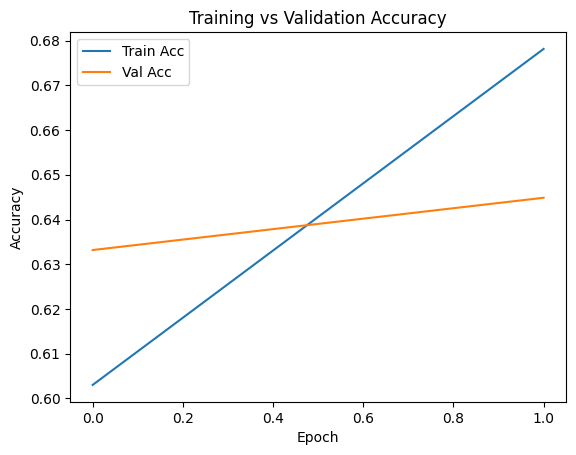

In [ ]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()


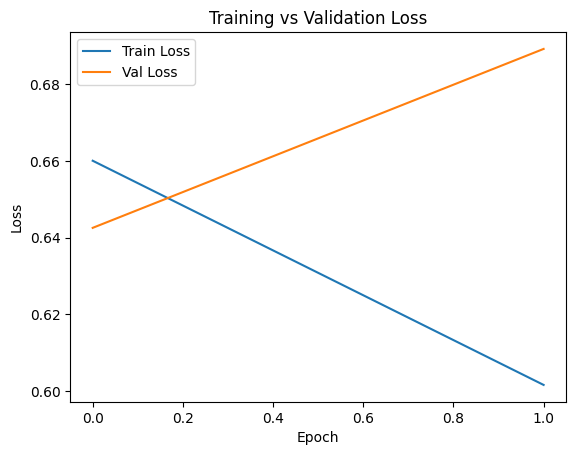

In [ ]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_x, y_test, batch_size=16)
print(f"Test accuracy: {test_acc:.3f}")


80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.6415 - loss: 0.6422
Test accuracy: 0.633


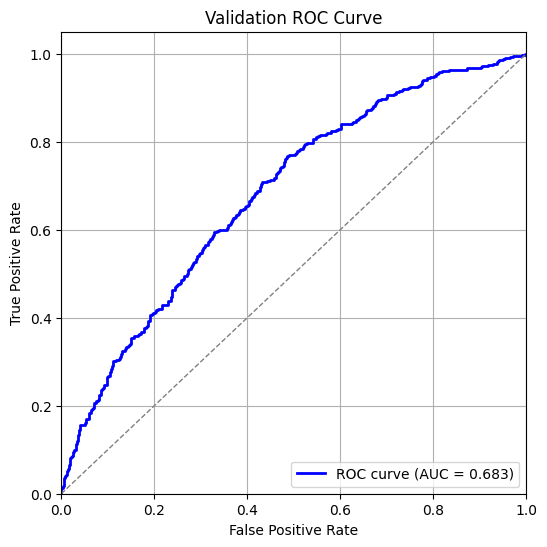

In [ ]:
# Predict probabilities on the validation set
val_logits = model.predict(val_x, batch_size=16, verbose=0).ravel()
val_probs  = tf.sigmoid(tf.constant(val_logits)).numpy()

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, val_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
# Predict probabilities on the test set
print("Test Performance:")

start_test = time.time() # Start timing the test inference

# Predict probabilities on the test set
logits = model.predict(test_x, batch_size=16, verbose=0).squeeze()
test_proba = tf.sigmoid(tf.convert_to_tensor(logits)).numpy().ravel()

test_pred = (test_proba >= 0.5).astype(int) # Predict binary labels based on threshold

end_test = time.time() # End timing the test inference

test_time = end_test - start_test
test_avg_time = test_time / len(y_test)

print(classification_report(y_test.astype(int), test_pred, digits=2))
print(f"Test inference time: {test_time:.4f} seconds")
print(f"Average time per test sample: {test_avg_time:.6f} seconds")

Test Performance:
              precision    recall  f1-score   support

           0       0.59      0.51      0.55       553
           1       0.66      0.73      0.69       714

    accuracy                           0.63      1267
   macro avg       0.62      0.62      0.62      1267
weighted avg       0.63      0.63      0.63      1267

Test inference time: 4.5843 seconds
Average time per test sample: 0.003618 seconds


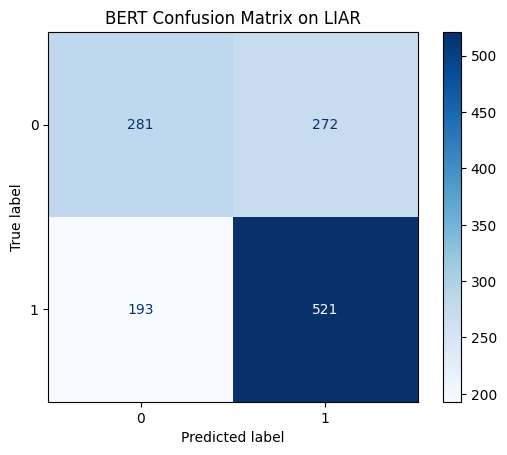

In [ ]:
# Calculate confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, test_pred)

# Display confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
cm_display.plot(cmap="Blues", values_format='d')
plt.title("BERT Confusion Matrix on LIAR")
plt.show()

In [ ]:
# Save the model
model.save("/content/drive/MyDrive/MS983/Models/liar_bert.keras")